In [101]:
# add number of delays per day over full dataset

In [197]:
import mca
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold

In [267]:
APK = pd.read_csv("./Stations/APK.csv")
GBG = pd.read_csv("./Stations/GBG.csv")
CLH = pd.read_csv("./Stations/CLH.csv", low_memory=False)
MP = pd.read_csv("./Stations/MP.csv")

rer = pd.concat([APK, GBG, CLH, MP], ignore_index=True)

CDG = pd.read_csv("./Stations/CDG.csv")
SL = pd.read_csv("./Stations/SL.csv")
SGP = pd.read_csv("./Stations/SGP.csv")
BL = pd.read_csv("./Stations/BL.csv")

metro = pd.concat([CDG, SL, SGP, BL], ignore_index=True)

In [270]:
rer['scheduled_arrival'] = pd.to_datetime(rer['scheduled_arrival'], format='%Y-%m-%d %H:%M:%S')
rer['pourc_validations'] = rer['pourc_validations'].fillna(0)
rer["departure_status"] = rer["departure_status"].astype("string")

metro['real_arrival'] = pd.to_datetime(metro['real_arrival'], format='%Y-%m-%d %H:%M:%S')
metro['pourc_validations'] = metro['pourc_validations'].fillna(0)
metro["departure_status"] = metro["departure_status"].astype("string")

start_date = pd.to_datetime('2024-11-02 00:00:00')

metro = metro[(metro['real_arrival'] >= start_date)]
rer = rer[(rer['scheduled_arrival'] >= start_date)]

# Summary Statistics

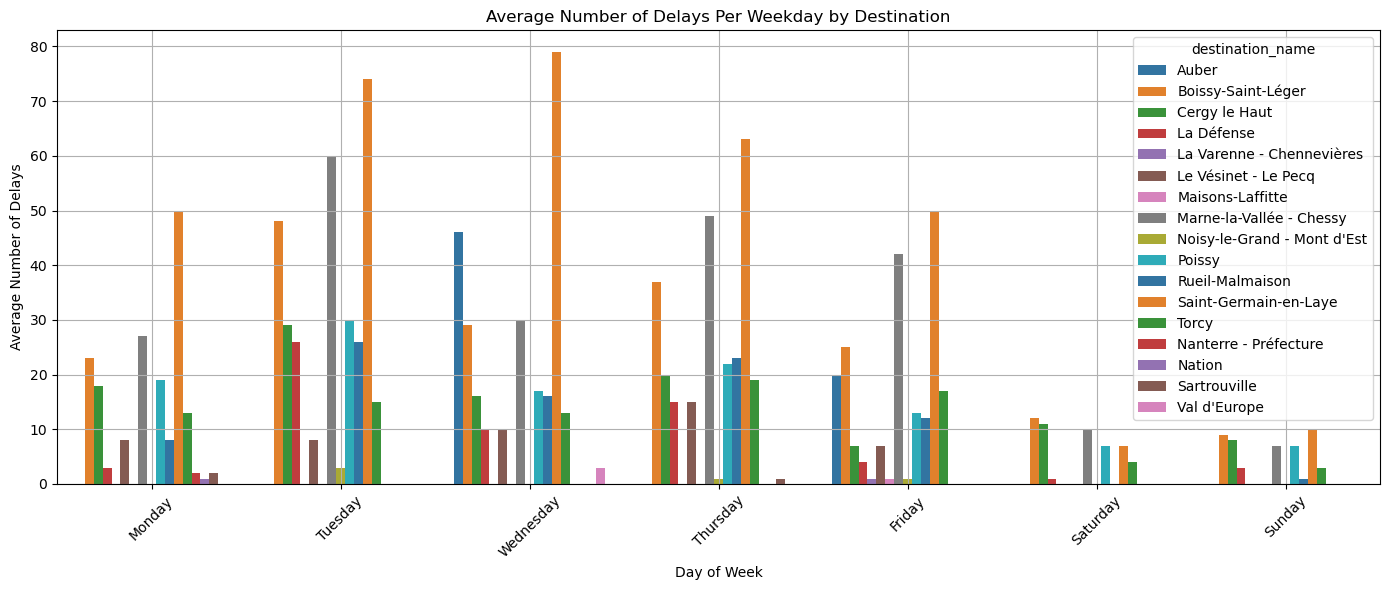

In [273]:
## for better readability, merge noth/south east/west directions

# Ensure the datetime column is in the correct format (if not already)
CLH['scheduled_arrival'] = pd.to_datetime(CLH['scheduled_arrival'])

# Filter for delayed departures
delayed_rer = CLH[CLH['departure_status'] == 'delayed']

# Add a 'day_of_week' column (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) using .loc
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['scheduled_arrival'].dt.dayofweek

# Map numerical days to actual weekday names using .loc
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['day_of_week'].map(day_names)

# Group by day of the week and destination_name, then count the number of delays
delayed_count_per_weekday = delayed_rer.groupby(['day_of_week', 'destination_name']).size().reset_index(name='delay_count')

# Calculate the average number of delays per weekday for each destination
average_delays_per_weekday = delayed_count_per_weekday.groupby(['day_of_week', 'destination_name'])['delay_count'].mean().reset_index()

# Sort by weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_delays_per_weekday['day_of_week'] = pd.Categorical(average_delays_per_weekday['day_of_week'], categories=ordered_days, ordered=True)

# Plot the average delays per weekday for each destination as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delays_per_weekday,
    x='day_of_week',
    y='delay_count',
    hue='destination_name',
    palette = "tab10"
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays Per Weekday by Destination')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [274]:
rer["stop_name"].value_counts()

stop_name
Châtelet - Les Halles          42900
Avenue du Président Kennedy    10890
Massy - Palaiseau               7418
Gare de Buno Gironville         3955
Name: count, dtype: int64

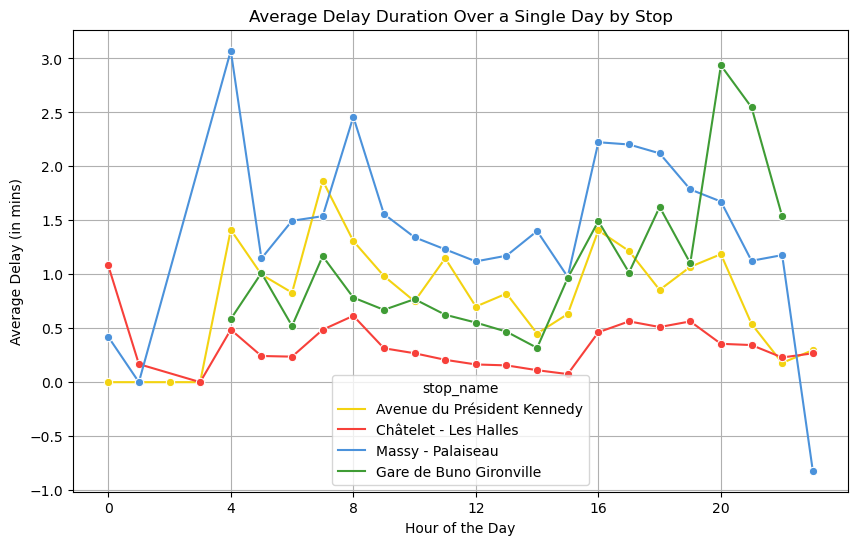

In [275]:
# Ensure datetime format
rer_filtered = rer[rer['arrival_difference'] <= 100].copy()
rer_filtered['hour'] = rer_filtered['scheduled_arrival'].dt.hour

# Group by 'hour' and 'ArRTown' to calculate mean delay
average_delay_by_category = rer_filtered.groupby(['hour', 'stop_name'])['arrival_difference'].mean().reset_index()

custom_palette = {
    'Massy - Palaiseau': '#4B92DB',
    'Avenue du Président Kennedy': '#F3D311',
    'Châtelet - Les Halles': '#F7403A',
    'Gare de Buno Gironville': '#3F9C35'
}

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=average_delay_by_category,
    x='hour',
    y='arrival_difference',
    hue='stop_name',
    palette=custom_palette,
    marker="o"
)

#plt.xticks(ticks=range(0, 24), labels=[str(hour) for hour in range(24)])
plt.gca().set_xticks(range(0, 24, 4))  # Major ticks every 4 hours

plt.xlabel('Hour of the Day')
plt.ylabel('Average Delay (in mins)')
plt.title('Average Delay Duration Over a Single Day by Stop')
plt.legend(title="stop_name")
plt.grid(True)
plt.savefig("./Figures/Average-Delay-Stop.png", format='png', dpi=300)
plt.show()


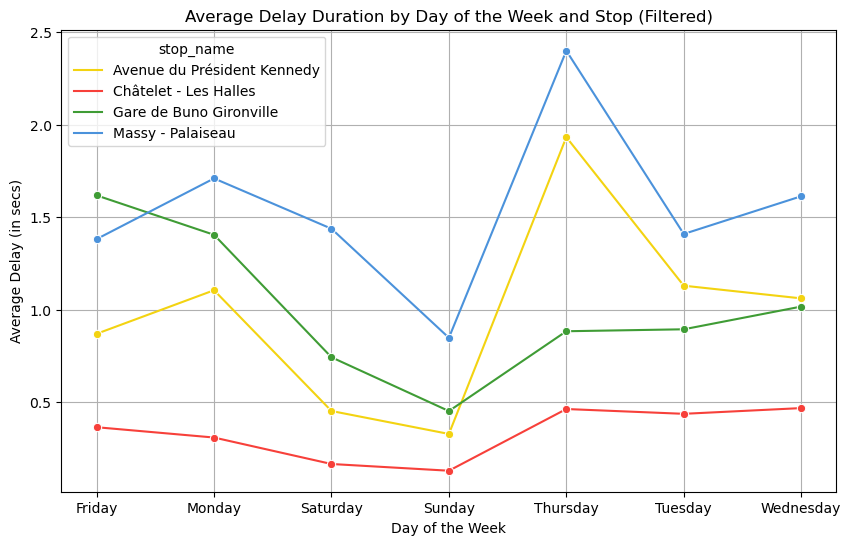

In [278]:
# Remove outliers where delay exceeds 100 seconds
rer_filtered = rer[rer['arrival_difference'] <= 100]

rer_filtered.loc[:, 'day_of_week'] = rer_filtered['scheduled_arrival'].dt.dayofweek
rer_filtered.loc[:, 'day_of_week'] = rer_filtered['day_of_week'].map(day_names)
rer_filtered.loc[:, 'day_of_week'] = pd.Categorical(
    rer_filtered['day_of_week'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

# Group by 'day_of_week' and 'ArRTown' to calculate mean delay
average_delay_by_day = rer_filtered.groupby(
    ['day_of_week', 'stop_name'], observed=False
)['arrival_difference'].mean().reset_index()


custom_palette = {
    'Massy - Palaiseau': '#4B92DB',
    'Avenue du Président Kennedy': '#F3D311',
    'Châtelet - Les Halles': '#F7403A',
    'Gare de Buno Gironville': '#3F9C35'
}

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=average_delay_by_day,
    x='day_of_week',
    y='arrival_difference',
    hue='stop_name',
    palette=custom_palette,
    marker="o"
)
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (in secs)')
plt.title('Average Delay Duration by Day of the Week and Stop (Filtered)')
plt.legend(title="stop_name")
plt.grid(True)
plt.savefig("./Figures/Average-Delay-DayOfWeek-Stop.png", format='png', dpi=300)
plt.show()


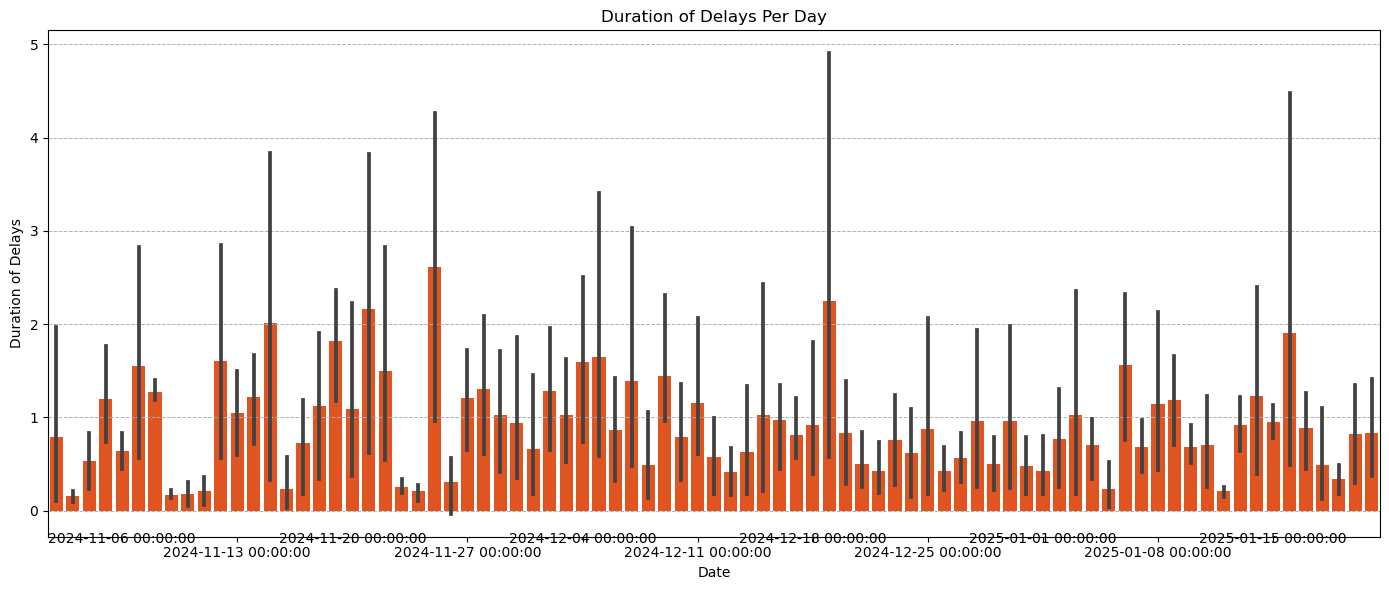

In [280]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
rer['Date'] = pd.to_datetime(rer['Date'])

# Filter for delayed departures
#delayed_rer = rer[rer['departure_status'] == 'delayed']

# Group by date and count the number of delays
#delayed_count_per_day = delayed_rer.groupby(delayed_rer['Date'].dt.date).size().reset_index(name='delay_count')
average_delay_by_category = rer_filtered.groupby(['Date', 'stop_name'])['arrival_difference'].mean().reset_index()

# Rename columns for clarity
average_delay_by_category.rename(columns={'Date': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
average_delay_by_category['date'] = pd.to_datetime(average_delay_by_category['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delay_by_category,
    x='date',
    y='arrival_difference',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Duration of Delays')
plt.title('Duration of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Duration-Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


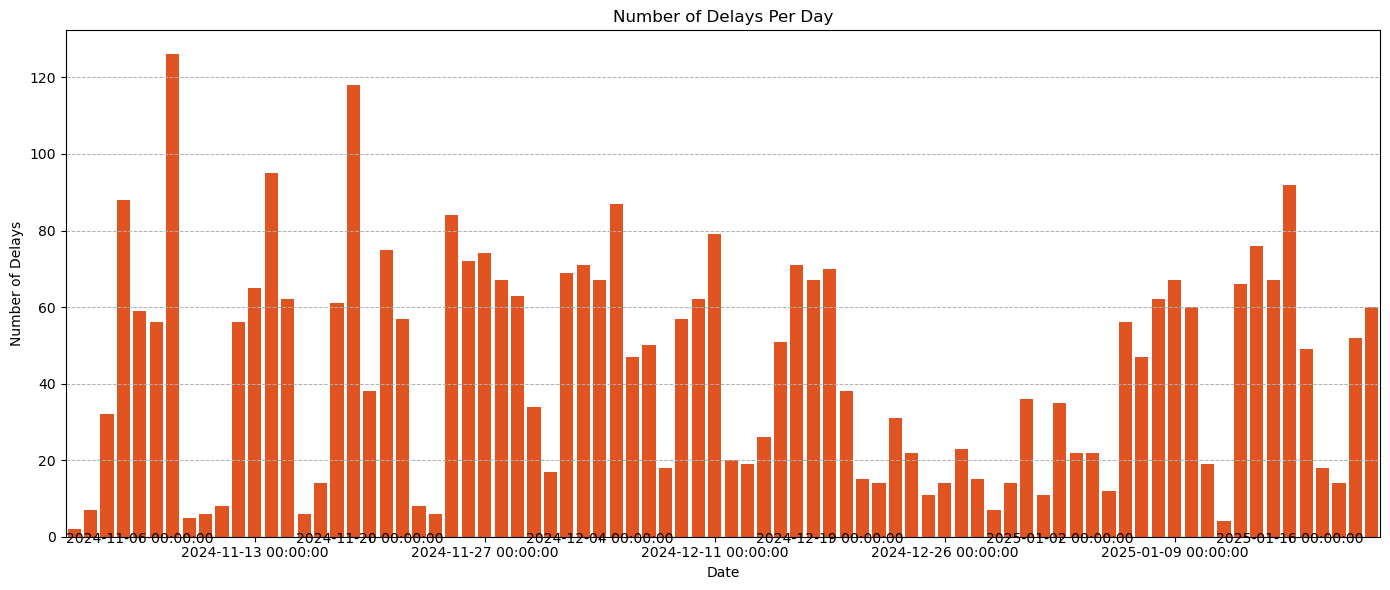

In [283]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
rer['Date'] = pd.to_datetime(rer['Date'])

# Filter for delayed departures
delayed_rer = rer[rer['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_rer.groupby(delayed_rer['Date'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'Date': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


In [211]:
# Select numerical variables
numerical_vars = metro_learn.select_dtypes(include=['float64'])

# Standardize the numerical variables
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(numerical_vars_scaled)

NameError: name 'metro_learn' is not defined

In [213]:
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(
    pca_results,
    columns=[f'PC{i+1}' for i in range(pca_results.shape[1])]
)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Output the PCA results and explained variance
print("Explained Variance Ratio:", explained_variance)
print("PCA DataFrame Head:\n", pca_df.head())

NameError: name 'pca_results' is not defined

In [215]:
# -or
# Assuming you already have your dataset loaded into 'APK' DataFrame and it's preprocessed

# Select numerical columns
numerical_vars = metro_learn.select_dtypes(include=['float64'])

# Standardize the data
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca.fit(numerical_vars_scaled)

# Eigenvalues (explained variance for each principal component)
eigval = pca.explained_variance_

# Number of components (k)
k = len(eigval)

# Scree plot
plt.plot(np.arange(1, k + 1), eigval, marker='o')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid(True)
plt.savefig('Screeplot.png', bbox_inches='tight', dpi=300)
plt.show()


NameError: name 'metro_learn' is not defined

In [217]:
plt.plot(np.arange(1,k+1),np.cumsum(pca.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors") 
plt.ylabel("Cumsum explained variance ratio") 
plt.xlabel("Factor number") 
plt.savefig('CumSumPlot.png', bbox_inches='tight', dpi=300)
plt.show()

NameError: name 'k' is not defined

In [219]:
## 5 factors picked for expainability

In [221]:
eigval

NameError: name 'eigval' is not defined

In [202]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.32883105 0.56766075 0.72139829 0.84537821 0.92350753 0.99134853
 0.99803734 1.        ]


In [153]:
# Assuming APK_learn is your DataFrame, and categorical columns are encoded as integers
# Select columns that are of integer type (numerical encoded categorical columns)
categorical_columns = APK_learn.select_dtypes(include=['int64']).columns

# Run MCA using the mca library, specifying n_components for multiple components
mca_model = mca.MCA(APK_learn[categorical_columns], ncols=7)  # Request 7 components

# Access the MCA results (coordinates of the data points in the reduced space)
mca_results = mca_model.fs_r()  # Call the function to get the result

# Create a DataFrame with the MCA results
mca_df = pd.DataFrame(mca_results, columns=[f'MCA{i+1}' for i in range(mca_results.shape[1])])

# Display the first few rows of the MCA results
print(mca_df.head())


       MCA1
0  0.090216
1  0.158122
2  0.119318
3  0.158122
4  0.090216


In [ ]:
# Optionally, you can plot the first two components (MCA1 vs MCA2)
plt.figure(figsize=(10, 6))
plt.scatter(mca_df['MCA1'], mca_df['MCA2'], alpha=0.5)
plt.title('MCA: First Two Components')
plt.xlabel('MCA1')
plt.ylabel('MCA2')
plt.grid(True)
plt.show()

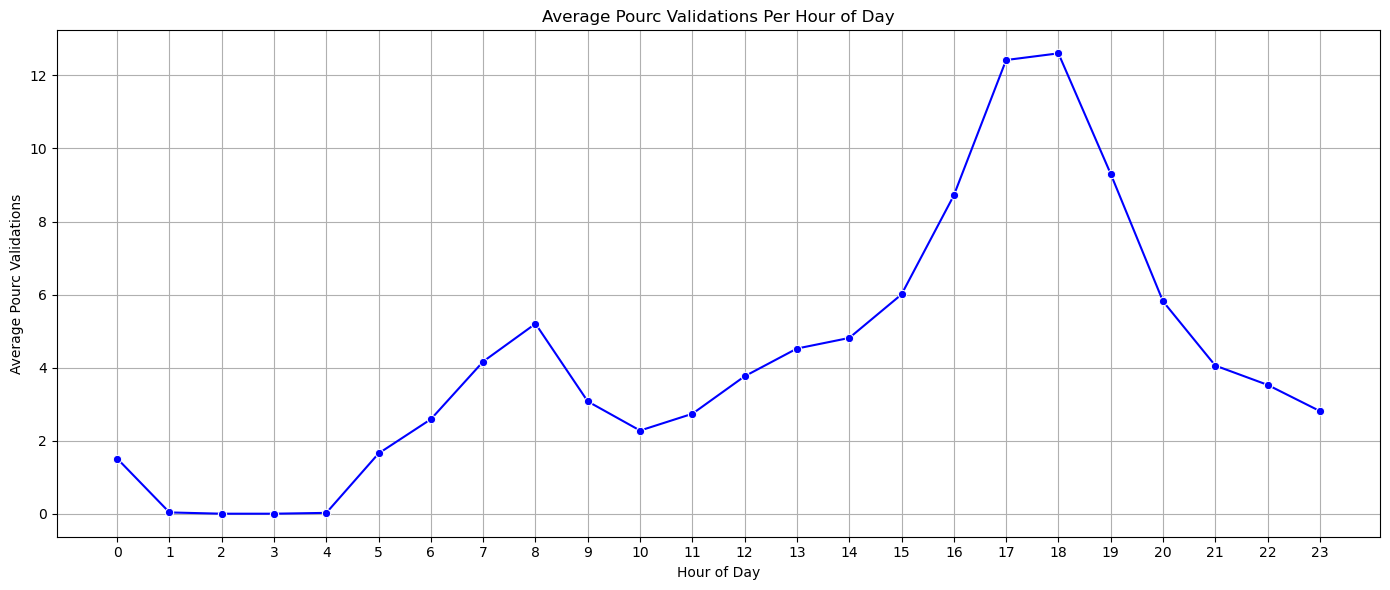

In [244]:
# Ensure the datetime column is in the correct format (if not already)
rer['scheduled_arrival'] = pd.to_datetime(rer['scheduled_arrival'])

# Extract hour from the datetime column
rer['hour'] = rer['scheduled_arrival'].dt.hour

# Group by hour and calculate the average pourc_validations
hourly_validations = rer.groupby('hour')['pourc_validations'].mean().reset_index()

# Plot the hourly average pourc_validations
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_validations,
    x='hour',
    y='pourc_validations',
    marker='o',
    color='b'  # Blue color for the line
)

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Pourc Validations')
plt.title('Average Pourc Validations Per Hour of Day')

# Set the x-ticks to be from 0 to 23 (representing hours)
plt.xticks(range(24))

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# metro

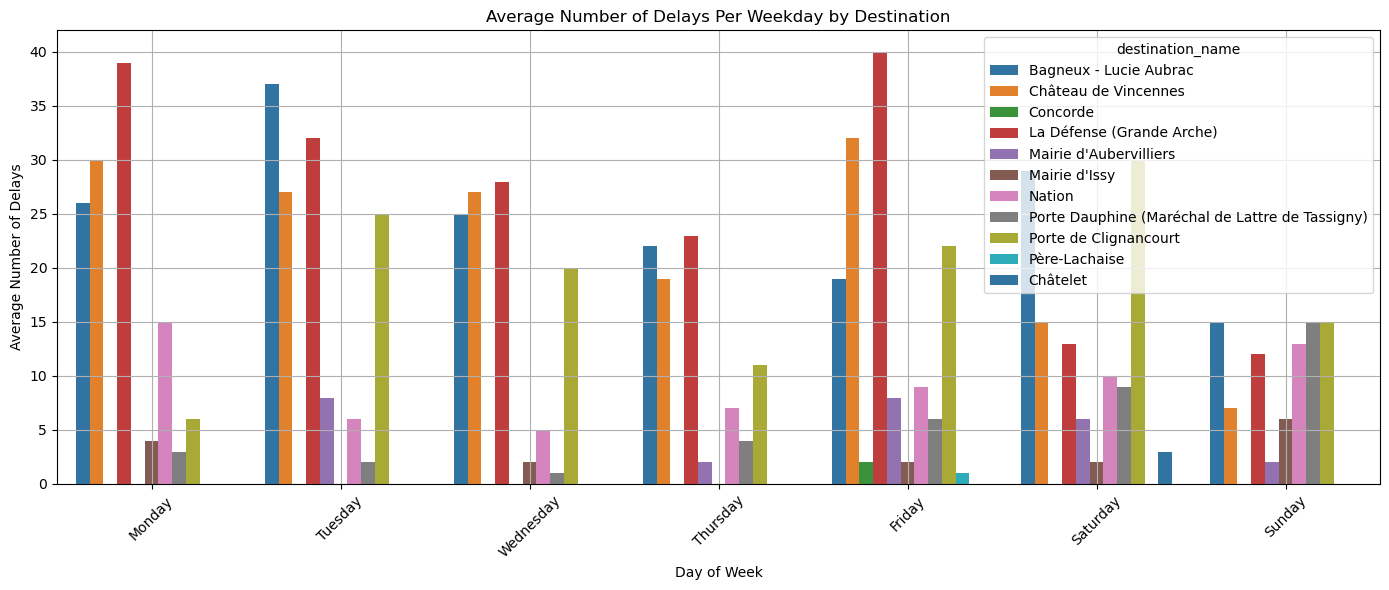

In [254]:
## for better readability, merge noth/south east/west directions

# Ensure the datetime column is in the correct format (if not already)
metro['real_arrival'] = pd.to_datetime(metro['real_arrival'])

# Filter for delayed departures
delayed_rer = metro[metro['departure_status'] == 'delayed']

# Add a 'day_of_week' column (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) using .loc
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['real_arrival'].dt.dayofweek

# Map numerical days to actual weekday names using .loc
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['day_of_week'].map(day_names)

# Group by day of the week and destination_name, then count the number of delays
delayed_count_per_weekday = delayed_rer.groupby(['day_of_week', 'destination_name']).size().reset_index(name='delay_count')

# Calculate the average number of delays per weekday for each destination
average_delays_per_weekday = delayed_count_per_weekday.groupby(['day_of_week', 'destination_name'])['delay_count'].mean().reset_index()

# Sort by weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_delays_per_weekday['day_of_week'] = pd.Categorical(average_delays_per_weekday['day_of_week'], categories=ordered_days, ordered=True)

# Plot the average delays per weekday for each destination as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delays_per_weekday,
    x='day_of_week',
    y='delay_count',
    hue='destination_name',
    palette = "tab10"
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays Per Weekday by Destination')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


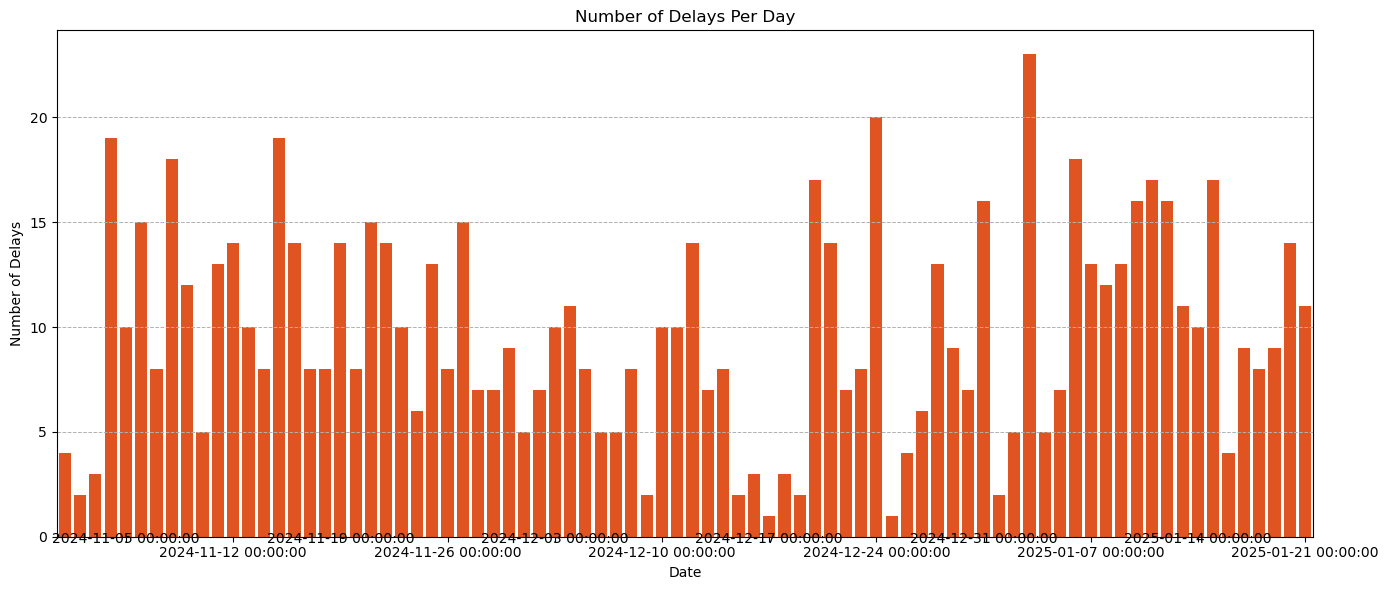

In [247]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
metro['real_arrival'] = pd.to_datetime(metro['real_arrival'])

# Filter for delayed departures
delayed_metro = metro[metro['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_metro.groupby(delayed_metro['real_arrival'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'real_arrival': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


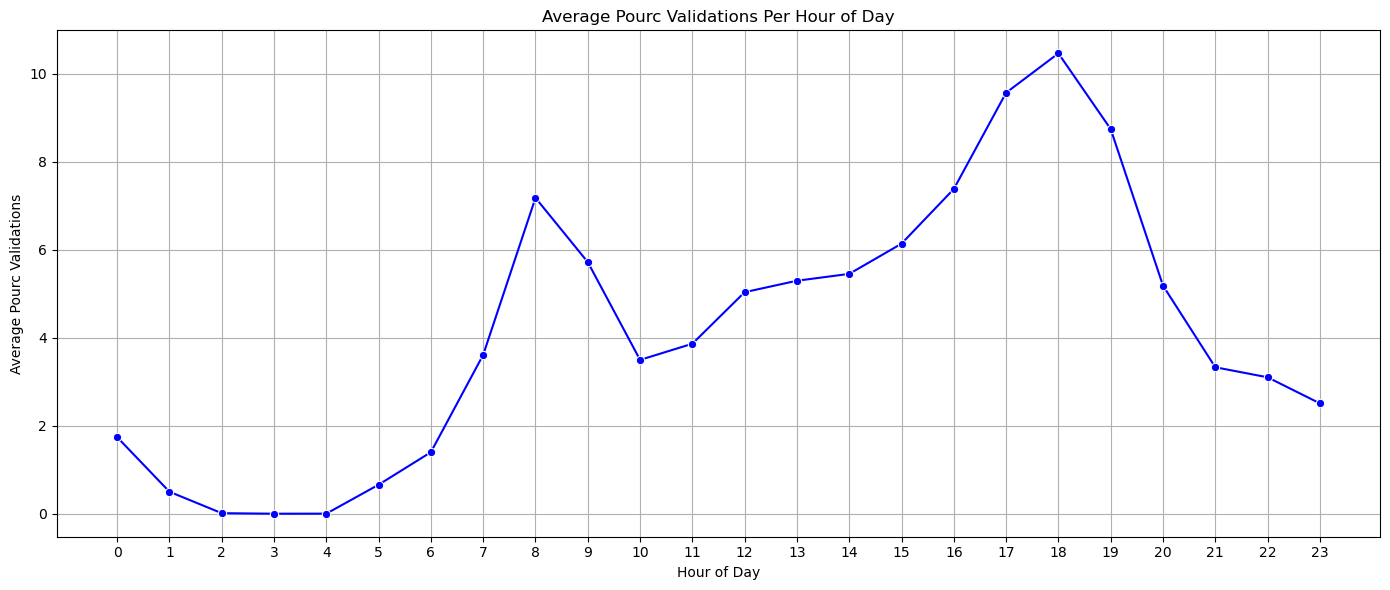

In [249]:
# Ensure the datetime column is in the correct format (if not already)
metro['real_arrival'] = pd.to_datetime(metro['real_arrival'])

# Extract hour from the datetime column
metro['hour'] = metro['real_arrival'].dt.hour

# Group by hour and calculate the average pourc_validations
hourly_validations = metro.groupby('hour')['pourc_validations'].mean().reset_index()

# Plot the hourly average pourc_validations
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_validations,
    x='hour',
    y='pourc_validations',
    marker='o',
    color='b'  # Blue color for the line
)

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Pourc Validations')
plt.title('Average Pourc Validations Per Hour of Day')

# Set the x-ticks to be from 0 to 23 (representing hours)
plt.xticks(range(24))

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
